# Folder Structure

* **airbus_dataset:** dataset from the Airbus Ship Detection Challenge
    * **test_v2:** test images from challenge (not really useful as we don't have ground truth)
    * **train_v2:** entire training dataset from the challenge (193k images with or without ships)
    * **train_v2_labels:** png images representing the masks of the images (currently only for images that have at least one ship). Generated from run-length encoding. Values in the png are either 0 (background) or 1 (ship), because that's how fast.ai wants it
    * **train_valid:** training and validation data for the model. Contains 36k images with ships, the rest (6556) are for testing
    * **codes.txt:** mapping from integers to classes for the masks, needed by fast.ai. Only two values, background and ship
    * **sample_submission_v2.csv:** from challenge, don't really need it
    * **train_ship_segmentation_v2.csv:** segmentation masks for the entire training dataset, in run-length encoding

* **models:** saved models
    * **unet_googlenet.pth:** unet model with googlenet as encoder, trained for hardcoded epochs according to unet for ship detection papers

* **unet.ipynb:** process data and train model

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fastai.vision.all import *
from PIL import Image
import os
import shutil
import pathlib

In [76]:
# load the segmentation masks (in run-length encoding format)
masks_rle = pd.read_csv('airbus_dataset/train_ship_segmentations_v2.csv').set_index('ImageId')

# select the names of images that have a ship
# 
# images that have a ship have str as the type of EncodedPixels, while images that 
# do not have a ship have float as the type of EncodedPixels
# 
# reference for lambda function: https://stackoverflow.com/questions/39275533/select-row-from-a-dataframe-based-on-the-type-of-the-objecti-e-str
ship_images = masks_rle[masks_rle['EncodedPixels'].apply(lambda x: isinstance(x, str))].index.unique().tolist()
print('Number of images with ships:', len(ship_images))

Number of images with ships: 42556


# Folder Structure

* **airbus_dataset:** dataset from the Airbus Ship Detection Challenge
    * **test_v2:** test images from challenge (not really useful as we don't have ground truth)
    * **train_v2:** entire training dataset from the challenge (193k images with or without ships)
    * **train_v2_labels:** png images representing the masks of the images (currently only for images that have at least one ship). Generated from run-length encoding. Values in the png are either 0 (background) or 1 (ship), because that's how fast.ai wants it
    * **train_valid:** training and validation data for the model. Contains 36k images with ships, the rest (6556) are for testing
    * **codes.txt:** mapping from integers to classes for the masks, needed by fast.ai. Only two values, background and ship
    * **sample_submission_v2.csv:** from challenge, don't really need it
    * **train_ship_segmentation_v2.csv:** segmentation masks for the entire training dataset, in run-length encoding

* **ship_detection:**
    * **models:** saved models
        * **unet_googlenet.pth:** unet model with googlenet as encoder, trained for hardcoded epochs according to unet for ship detection papers

    * **unet.ipynb:** process data and train model

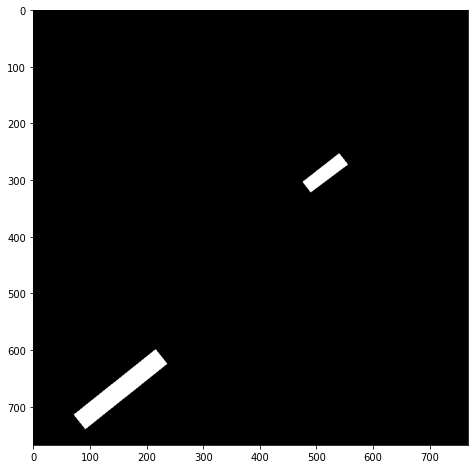

In [227]:
# generate the full image mask of an image from run-length encoding
def get_image_mask(image_id):
    # create a 1D array equal to legnth*width of the initial image 
    image_mask = np.zeros(768*768)

    # get all the ship masks in the image
    # slicing necessary to ensure loc returns df of masks, not actual value of mask
    for mask in masks_rle.loc[image_id:image_id]['EncodedPixels']: 
        mask = mask.split()
        mask = [int(i) for i in mask]
        for i in range(0, len(mask), 2):
            image_mask[mask[i]:mask[i]+mask[i+1]] = 1

    # reshape the image mask
    image_mask = image_mask.reshape([768, 768]).T
    
    return image_mask

img_id = '0005d01c8.jpg'
plt.figure(figsize=(8,8))
plt.imshow(get_image_mask(img_id), cmap='Greys_r')


In [228]:
# save all the masks (targets) as png files
#   path - folder in which to save the images
#   images - images for which to save masks
def save_masks_png(path, images):

    # loop through all images that have at least a ship
    for image in images:

        # check that the image contains a ship
        if image in ship_images:

            # get the corresponding mask as numpy array
            mask = get_image_mask(image)
            mask_img = Image.fromarray(mask).convert('RGB')
            mask_img.save(path + image[:-4] + '_P.png')

save_masks_png('airbus_dataset/train_v2_labels/', ship_images)

# check how many files are in the labels directory
c = 0
for file in os.listdir('airbus_dataset/train_v2_labels/'):
    c += 1
print('Number of labels:', c)

Number of labels: 42556


In [229]:
# split the data into train, validation and test
# only use images that contain at least one ship
# 
#   train: 30K images
#   validation: 6K images
#   test: approx. 6K (rest of images with ships in them)
# 
# the sets will contain image ids

# first split into train + validation and test
train_validation_data, test_data = train_test_split(ship_images, train_size=36000)

# further split into train and validation
train_data, validation_data = train_test_split(train_validation_data, train_size=30000)

print('Images in training dataset:', len(train_data))
print('Images in validation dataset:', len(validation_data))
print('Images in test dataset:', len(test_data))

# need to copy all images in the train + validation subset to another folder,
# in order to use the fast.ai functions to create a datablock

# remove all files currently in the train_valid folder
for file in os.listdir('airbus_dataset/train_valid'):
    os.remove('airbus_dataset/train_valid/' + file)

# copy all files in the train + validation subset to the train_valid subfolder
for file in train_validation_data:
    src = 'airbus_dataset/train_v2/' + file
    dst = 'airbus_dataset/train_valid/' + file
    shutil.copy(src, dst)

# print the number of files in the train_valid folder
c = 0
for file in os.listdir('airbus_dataset/train_valid/'):
    c += 1
print('Number of training and validation images:', c)

Images in training dataset: 30000
Images in validation dataset: 6000
Images in test dataset: 6556
Number of training and validation images: 36000


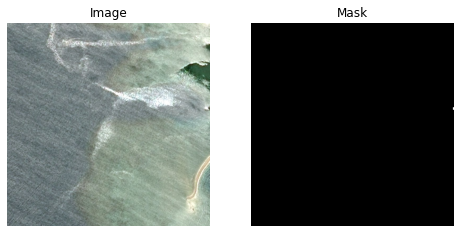

In [252]:
# get the path of the current working directory
path = pathlib.Path().resolve()

# define a function that gets the label for a given image
def label_func(fn): return path/"airbus_dataset/train_v2_labels"/f"{fn.stem}_P.png"

# create a datablock
dblock = DataBlock(
    blocks=(ImageBlock, MaskBlock(np.loadtxt(path/'airbus_dataset'/'codes.txt', dtype=str))),
    get_items=get_image_files,
    get_y=label_func,
    splitter=RandomSplitter(), # splits data into training and validation (0.2 for validation)
    item_tfms=Resize(224), # resize images to 224x224
)

# create a dataset from the datablock
dsets = dblock.datasets(path/'airbus_dataset/train_valid/')

# show an example of training image and its corresponding mask
fig = plt.figure(figsize=(8, 4))
fig.add_subplot(1, 2, 1)
plt.imshow(dsets.train[0][0])
plt.axis('off')
plt.title('Image')
fig.add_subplot(1, 2, 2)
plt.imshow(dsets.train[0][1], cmap='Greys_r')
plt.axis('off')
plt.title('Mask')
plt.show()

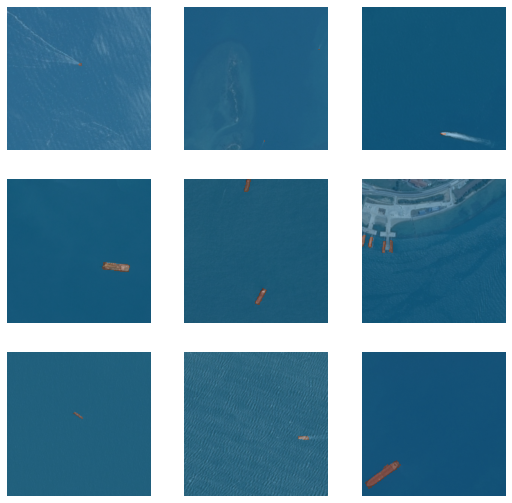

In [248]:
# create a dataloader
dls = dblock.dataloaders(path/'airbus_dataset/train_valid/', bs=16)
dls.show_batch()

In [232]:
# create a unet learner
learn = unet_learner(dls, googlenet,
    self_attention=True,
    loss_func=FocalLoss(),
    lr=1e-4
)

learn.summary()

c:\Users\TXD\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\TXD\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DynamicUnet (Input shape: 16 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     16 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     16 x 192 x 56 x 56  
Conv2d                                    110592     False     
BatchNorm2d                               384        True      
____________________________________________________________________________
                     16 x 192 x 28 x 28  
MaxPool2d                                  

In [233]:
### 1st TRAINING PHASE ###
# freeze encoder
# one cycle policy
# lr = 1e-4
# 3 epochs
learn.fit_one_cycle(3)

### 2nd TRAINING PHASE ###
# unfreeze encoder
# 4 more epochs
# other hyperparameters are the same
learn.unfreeze()
learn.fit_one_cycle(4)

# same the model
learn.save('unet_googlenet')

epoch,train_loss,valid_loss,time


KeyboardInterrupt: 

<PIL.PngImagePlugin.PngImageFile image mode=L size=128x96>
[[ 4  4  4 ...  4  4  4]
 [ 4  4  4 ...  4  4  4]
 [ 4  4  4 ...  4  4  4]
 ...
 [19 19 19 ... 30 30 30]
 [19 19 19 ... 30 30 30]
 [19 19 19 ... 30 30 30]]


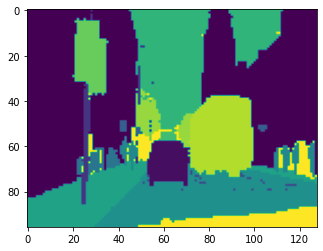

In [256]:
# some tests
camvid_img = Image.open(Path('C:/Users/TXD/.fastai/data/camvid_tiny/labels/0001TP_006750_P.png'))
plt.imshow(camvid_img)
print(camvid_img)
camvid_np = np.array(camvid_img)
print(camvid_np)